# Olist Cleaning and Checking Data Walkthrough

### Introduction

In this lesson we'll work with data from the [Olist Kaggle Competition](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

We'll walk you through our steps in working with the data.

### Loading our data

We can list all of the data in a given directory with the following.

In [1]:
# import os
# os.listdir('olist-data')

Which would output the below list.

In [15]:
datasets = ["olist_customers_dataset.csv", "olist_orders_dataset.csv",
"olist_geolocation_dataset.csv", "olist_products_dataset.csv",
"olist_order_items_dataset.csv", "olist_sellers_dataset.csv",
"olist_order_payments_dataset.csv", "product_category_name_translation.csv",
"olist_order_reviews_dataset.csv"]

And then, we can loop through our datasets, adding a key as the name of the dataset, and as a value storing the dataframe.

In [17]:
import os
import pandas as pd
root_url = "s3://jigsaw-labs-student"
dataframe_set = {}

for csv_file in datasets:
    names = csv_file.split('_')[1:-1]
    full_name = '_'.join(names)
    dataframe_set[full_name] = pd.read_csv(f'{root_url}/olist-data/{csv_file}')

In [18]:
dataframe_set.keys()

dict_keys(['customers', 'orders', 'geolocation', 'products', 'order_items', 'sellers', 'order_payments', 'category_name', 'order_reviews'])

So above, we created a dictionary, where the keys are the names of the datasets and the values are the actual dataframes.

> For example, if we want to get the geolocation dataframe, we can with the following.

In [124]:
dataframe_set['geolocation'][:2]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


It would be a lot to work with all of our datasets at once -- so looking at our data, what do you think some of the key datasets are?

In [20]:
print(datasets)

['olist_customers_dataset.csv', 'olist_orders_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_products_dataset.csv', 'olist_order_items_dataset.csv', 'olist_sellers_dataset.csv', 'olist_order_payments_dataset.csv', 'product_category_name_translation.csv', 'olist_order_reviews_dataset.csv']


For this, we should probably first identify our join table -- orders, and then work from there.  It turns out each order is more like a shopping cart, with many order items.  So we'll join the orders, order_items, customers and products datasets.  

In [22]:
orders_df = dataframe_set['orders']
orders_customers_df = orders_df.merge(dataframe_set['customers'], on = 'customer_id')
orders_products_df = orders_customers_df.merge(dataframe_set['order_items'], on = 'order_id').merge(dataframe_set['products'], on = 'product_id')
# dataframe_set['customers']

orders_products_df[:2]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0


1. Understanding the grain of the data

Here, each row represents each individual **item** in a particular `order`.  And we can think of an order as a shopping cart experience.  So each row is an item that was purchased in a shopping cart.  We can confirm that an order consists of multiple items with a call to value_counts().

In [25]:
orders_products_df['order_id'].value_counts()[:3]

8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
Name: order_id, dtype: int64

2. Identifying the target of the data

For the target of the data, we can choose the price.  

### Cleaning the data

Now before cleaning the data, we can probably remove some of our columns. Currently, we have 26 columns from merging our three dataframes. 

In [1]:
# orders_products_df.columns

> Let's just select the relevant columns below.  We chose nine columns, and began to group them.

In [33]:
target_cols = ['price']

id_cols = ['order_id', 'customer_id', 'product_id']
order_cols = [ 'order_purchase_timestamp']
customer_cols = ['customer_zip_code_prefix', 'customer_city', 'customer_state']
product_cols = ['product_category_name']

selected_cols = order_cols + customer_cols + product_cols + id_cols + target_cols
print(selected_cols)

['order_purchase_timestamp', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'product_category_name', 'order_id', 'customer_id', 'product_id', 'price']


In [37]:
selected_df = orders_products_df[selected_cols]
selected_df[:2]

,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,product_category_name,order_id,customer_id,product_id,price
0,2017-10-02 10:56:33,3149,sao paulo,SP,utilidades_domesticas,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99
1,2017-08-15 18:29:31,3366,sao paulo,SP,utilidades_domesticas,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,29.99


> Ok, let's just show you the columns we chose.

In [40]:
target_cols = ['price']

id_cols = ['order_id', 'customer_id', 'product_id']
order_cols = [ 'order_purchase_timestamp']
customer_cols = ['customer_zip_code_prefix', 'customer_city', 'customer_state']
product_cols = ['product_category_name']

selected_cols = order_cols + customer_cols + product_cols + id_cols + target_cols
print(selected_cols)

['order_purchase_timestamp', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'product_category_name', 'order_id', 'customer_id', 'product_id', 'price']


> And then we can select just those columns, and rename one of the columns.

In [39]:
orders_products_df[selected_cols]

updated_selected_df = selected_df.rename(columns = {'order_purchase_timestamp': 'purchase_time'})
updated_selected_df[:2]

,purchase_time,customer_zip_code_prefix,customer_city,customer_state,product_category_name,order_id,customer_id,product_id,price
0,2017-10-02 10:56:33,3149,sao paulo,SP,utilidades_domesticas,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99
1,2017-08-15 18:29:31,3366,sao paulo,SP,utilidades_domesticas,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,29.99


#### 2. Cleaning our data

Now that we have merged together our datasets, identified the target and grain of the data, and then selected (pretty liberally) our relevant columns, it's time to clean our data.

1. Confirming the correct datatype

First, let's ensure that the columns are of the correct datatype.

In [36]:
updated_selected_df.dtypes

# purchase_time                object
# customer_zip_code_prefix      int64
# customer_city                object
# customer_state               object
# product_category_name        object
# order_id                     object
# customer_id                  object
# product_id                   object
# price                       float64
# dtype: object

purchase_time                object
customer_zip_code_prefix      int64
customer_city                object
customer_state               object
product_category_name        object
order_id                     object
customer_id                  object
product_id                   object
price                       float64
dtype: object

Remember that we are essentially looking for columns that we should change from object to something else.  

> Above, these look pretty good, except for our `purchase_time` column, which we should change to be datetime.

> The `id` columns could being changed to be numeric -- however there doesn't appear to be much downside to leaving them as is.

2. Extracting datepart columns

Ok, so next we can use our `add_datepart` function to extract additional columns. 

In [46]:
from item_lib import *

In [47]:
import warnings
warnings.filterwarnings('ignore')

selected_w_dates_df = updated_selected_df.copy()

fldnames = ['purchase_time']
add_datepart(selected_w_dates_df, fldnames)

In [48]:
selected_w_dates_df[:3]

,customer_zip_code_prefix,customer_city,customer_state,product_category_name,order_id,customer_id,product_id,price,purchase_timeYear,purchase_timeMonth,purchase_timeWeek,purchase_timeDay,purchase_timeDayofweek,purchase_timeDayofyear,purchase_timeElapsed
0,3149,sao paulo,SP,utilidades_domesticas,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,2017,10,40,2,0,275,1506941793
1,3366,sao paulo,SP,utilidades_domesticas,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,29.99,2017,8,33,15,1,227,1502821771
2,2290,sao paulo,SP,utilidades_domesticas,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,87285b34884572647811a353c7ac498a,29.99,2017,8,31,2,2,214,1501698287


### 3. Checking the representativeness of our data

* Selecting the relevant columns

We can begin by selecting the relevant columns -- here we can add the datetime columns to the list, which are at the end.

In [49]:
selected_w_dates_df.columns[8:]

Index(['purchase_timeYear', 'purchase_timeMonth', 'purchase_timeWeek',
       'purchase_timeDay', 'purchase_timeDayofweek', 'purchase_timeDayofyear',
       'purchase_timeElapsed'],
      dtype='object')

In [50]:
target_cols = ['price']

id_cols = ['order_id', 'customer_id', 'product_id']

customer_cols = ['customer_zip_code_prefix', 'customer_city', 'customer_state']
product_cols = ['product_category_name']
purchase_time_cols = ['purchase_timeYear', 'purchase_timeMonth', 'purchase_timeWeek',
       'purchase_timeDay', 'purchase_timeDayofweek', 'purchase_timeDayofyear',
       'purchase_timeElapsed']

selected_cols = customer_cols + product_cols + id_cols + purchase_time_cols + target_cols

From here, let's look at the representativeness of the data.  

As always, there are two main things to focus on here -- the time columns, and the target.  

1. Exploring the time columns

> Let's first use the describe function to explore the olist data

In [51]:
selected_w_dates_df[purchase_time_cols].describe()

,purchase_timeYear,purchase_timeMonth,purchase_timeWeek,purchase_timeDay,purchase_timeDayofweek,purchase_timeDayofyear,purchase_timeElapsed
count,112650.000000,112650.000000,112650.000000,112650.000000,112650.000000,112650.000000,1.126500e+05
mean,2017.541909,6.026835,24.338686,15.558331,2.745850,167.578029,1.514765e+09
std,0.504792,3.232541,14.056993,8.664745,1.963419,98.703801,1.323155e+07
min,2016.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.473024e+09
25%,2017.000000,3.000000,13.000000,8.000000,1.000000,85.000000,1.505330e+09
50%,2018.000000,6.000000,23.000000,16.000000,3.000000,162.000000,1.516403e+09
75%,2018.000000,8.000000,34.000000,23.000000,4.000000,233.000000,1.525455e+09
max,2018.000000,12.000000,52.000000,31.000000,6.000000,365.000000,1.535966e+09


> It's a bit much to plot all six of our time columns, so let's just look at the distributions of the first three.

array([[<AxesSubplot: title={'center': 'purchase_timeYear'}>,
        <AxesSubplot: title={'center': 'purchase_timeMonth'}>],
       [<AxesSubplot: title={'center': 'purchase_timeWeek'}>,
        <AxesSubplot: >]], dtype=object)

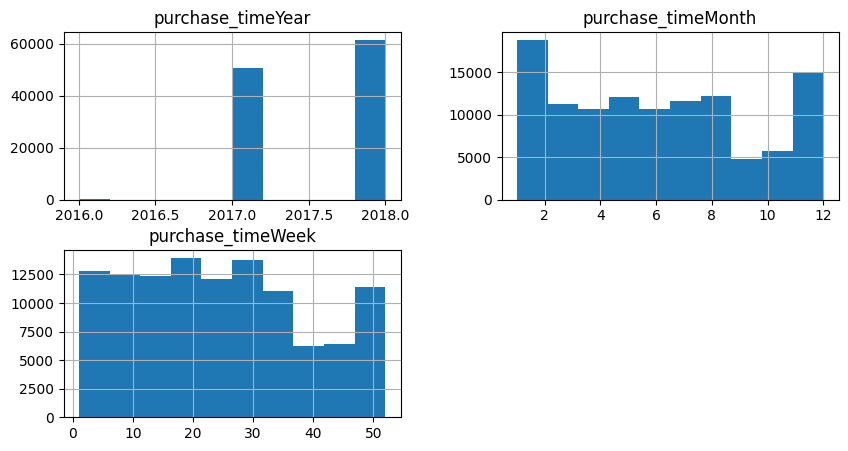

In [52]:
selected_w_dates_df[purchase_time_cols[:3]].hist(figsize=(10,5))

It looks like we only have a few rows from 2016 -- whereas the data between 2017 and 2018 appears more even.  We could do more research to see if the 2017 data has missing data, but as a bare minimum, let's remove the 2016 data.  After all, we would not want to make any conclusions about what occurred in 2016. 

In [53]:
selected_df_2017_plus = selected_w_dates_df[selected_w_dates_df['purchase_timeYear'] > 2016]
selected_df_2017_plus[:2]

,customer_zip_code_prefix,customer_city,customer_state,product_category_name,order_id,customer_id,product_id,price,purchase_timeYear,purchase_timeMonth,purchase_timeWeek,purchase_timeDay,purchase_timeDayofweek,purchase_timeDayofyear,purchase_timeElapsed
0,3149,sao paulo,SP,utilidades_domesticas,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,2017,10,40,2,0,275,1506941793
1,3366,sao paulo,SP,utilidades_domesticas,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,29.99,2017,8,33,15,1,227,1502821771


Ok now let's look at our two years individually.  We can plot purchases across days for each year - starting with 2017.

<AxesSubplot: >

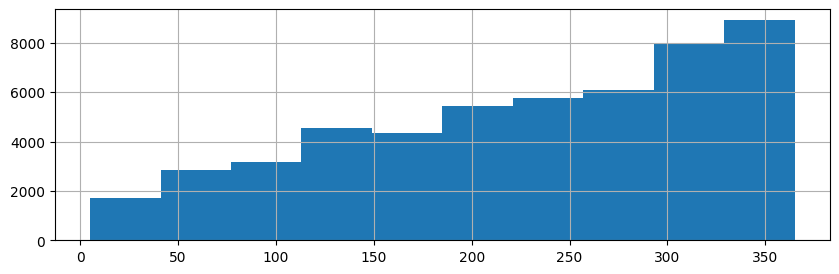

In [56]:
df_2017 = selected_w_dates_df[selected_w_dates_df['purchase_timeYear'] == 2017]
df_2017['purchase_timeDayofyear'].hist(figsize=(10,3))

And let's do the same for 2018.

<AxesSubplot: >

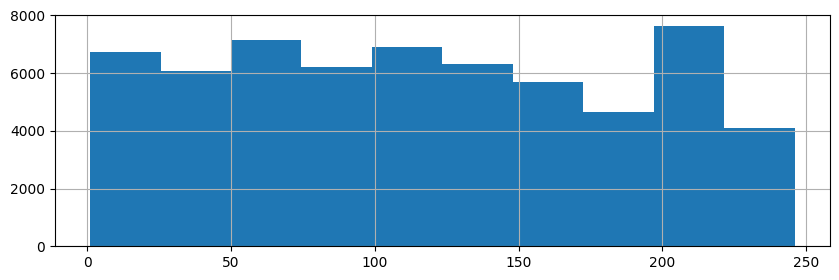

In [55]:
df_2018 = selected_w_dates_df[selected_w_dates_df['purchase_timeYear'] == 2018]


df_2018['purchase_timeDayofyear'].hist(figsize=(10,3))

Looking at this data, we can see that:

1. There is a trend of increasing data throughout 2017, whereas 2018 is more even.  
2. We're missing data from the end of 2018 (it ends at day 245 or so).

For the 2017 data, it would be good to learn more about whether this data is in fact complete (it could be missing, or it could just be that the company is increasing in popularity during that time).  How?  Well, in the real world, we would ask someone.

Until we learn more about the quality of our data, we probably should not trying to compare one year to another (we only have two years of data, and 2017 may be compromised).  Instead, let's just select a year's worth of data.   

To do so, we can first look at the maximum date for 2018.  This way we can select one years worth of data by just moving backwards one year.

In [84]:
df_2018['purchase_timeDayofyear'].describe()

count    61416.000000
mean       117.402403
std         68.884850
min          1.000000
25%         58.000000
50%        115.000000
75%        177.000000
max        246.000000
Name: purchase_timeDayofyear, dtype: float64

In [86]:
df_2017['purchase_timeDayofyear'].describe()

count    50864.000000
mean       227.343052
std         95.619374
min          5.000000
25%        151.000000
50%        242.000000
75%        317.000000
max        365.000000
Name: purchase_timeDayofyear, dtype: float64

So let's select our data from after 2017, day 246, as our 2018 ends at day 246.

> One way to do that is just to select data after a certain purchase time elapsed.

In [59]:
selected_full_year_df = selected_w_dates_df[selected_w_dates_df['purchase_timeElapsed'] > 1504486129]

And we can see that we have a full year of data.

<AxesSubplot: >

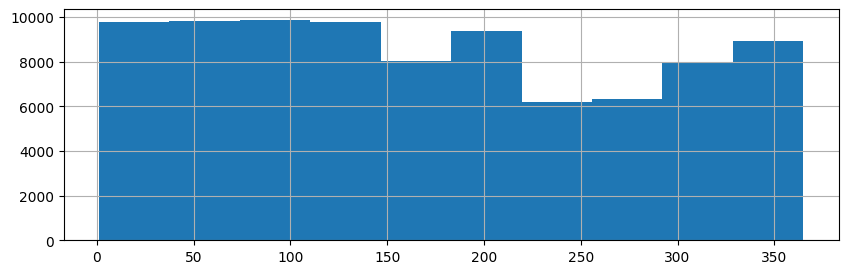

In [60]:
selected_full_year_df['purchase_timeDayofyear'].hist(figsize=(10,3))

So all of that was just to explore, and properly select data from a representative range of time.  Crazy, I know.

### 2. Exploring the target

Ok, next let's explore the target.  We want to check for missing data, or values that could be incorrect.

In [61]:
selected_full_year_df['price'].describe()

count    86098.000000
mean       120.262518
std        178.442271
min          0.850000
25%         39.990000
50%         75.000000
75%        135.000000
max       6729.000000
Name: price, dtype: float64

One thing we notice off of the bat, is that there are no items that have a price of 0, or negative numbers, indicating that we do not have any nonsensical data.

The maximum price of `6729` may indicate that incorrect data.  Let's see if this is an outlier by plotting a histogram of the data.  

<AxesSubplot: >

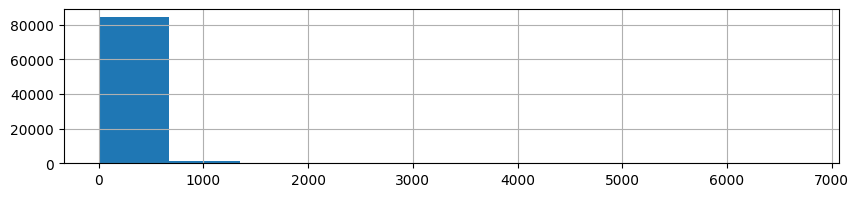

In [67]:
selected_full_year_df['price'].hist(figsize = (10, 2))

Ok, let's zoom in by playing with the range.

<AxesSubplot: >

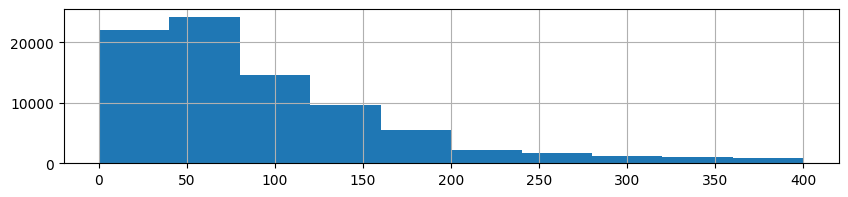

In [69]:
selected_full_year_df['price'].hist(figsize = (10, 2), range=[0, 400])

It looks like the vast majority of our products are within 0 and 400 dollars.  So let's take a look at just the highest priced products to at least see if this information makes sense -- or should be excluded.

In [104]:
sorted_by_price_df = selected_full_year_df.sort_values('price', ascending = False)
sorted_by_price_df[['product_category_name', 'price']][:10]

,product_category_name,price
84179,pcs,6729.00
92165,pcs,4590.00
63788,instrumentos_musicais,4399.87
75245,consoles_games,4099.99
34503,esporte_lazer,4059.00
104126,ferramentas_jardim,3930.00
105963,bebes,3899.00
88159,relogios_presentes,3700.00
34504,esporte_lazer,3690.00
34668,pcs,3399.99


Ok, so it doesn't look like our data is incorrect.  Rather we have some high priced categories -- like electronics, musical instruments, and garden tools (ferramentes jardim).

Also, these purchases are from Brazil so we should divide them by ~5 to see the equivalent price in USD.

In [110]:
df_us_d = sorted_by_price_df[['product_category_name', 'price']].assign(us_price = sorted_by_price_df['price']/5)
df_us_d[:5]

,product_category_name,price,us_price
84179,pcs,6729.00,1345.800
92165,pcs,4590.00,918.000
63788,instrumentos_musicais,4399.87,879.974
75245,consoles_games,4099.99,819.998
34503,esporte_lazer,4059.00,811.800


Ok, let's also take a look at our least priced items.

In [114]:
sorted_by_price_df_asc = selected_full_year_df.sort_values('price', ascending = True)
sorted_by_price_df_asc[['product_category_name', 'price']].assign(us_price = sorted_by_price_df['price']/5)[:10]

,product_category_name,price,us_price
98296,construcao_ferramentas_construcao,0.85,0.170
98298,construcao_ferramentas_construcao,0.85,0.170
98297,construcao_ferramentas_construcao,0.85,0.170
111794,beleza_saude,2.20,0.440
63662,papelaria,2.29,0.458
76894,papelaria,2.99,0.598
88982,NaN,3.00,0.600
88981,NaN,3.00,0.600
109007,utilidades_domesticas,3.06,0.612
109005,utilidades_domesticas,3.06,0.612


This translates to construction tools, and perhaps are items like screws or washers (or discounted screws and washers) -- explaining the cheap price.

Still, this data looks accurate, and we now have a complete year's worth of data, which we can save to csv and work with as we explore our data. 

In [122]:
selected_full_year_df.to_csv('./olist_2017_2018.csv', index = False)

### Takeaways

Ok, so what can we takeaway from the above.  

0. Merging data

In [ ]:
orders_df = dataframe_set['orders']
orders_customers_df = orders_df.merge(dataframe_set['customers'], on = 'customer_id')
orders_products_df = orders_customers_df.merge(dataframe_set['order_items'], on = 'order_id').merge(dataframe_set['products'], on = 'product_id')

1. Initial identification

* Of the grain of the data (here it was individual order items)
* Of the target (here it was the price)

2. Initial cleanup

We select relevant columns, checked the datatypes, and used the `add_datepart` function to break the purchase datetime into multiple attributes.

3. Checking the representativeness of the data

* Time periods

We then looked at a distribution of our data, to get a sense of our time period.  We saw we had what looked like complete data from the end of 2017 to the (almost) end of 2018.  So we selected one year's worth of data.  

So we did not feel like we could calculate year over year data -- perhaps we could follow up to see if we have complete 2017 data, or can obtain it.

* Target

Because the target is what we are trying to predict, we paid special attention to it.  Using the `describe` function, our data fell within a sensible range -- there were no negative or zero prices.  And we saw tht most of the prices were below 400 pesos (~80 US), but that some reached $6000 pesos.

So we looked at the lower and upper values to make sure that seemed like accurate prices, adn we're not inaccurate data.  They seemed reasonable, so we kept them.